In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
pip install larq

In [2]:
import numpy as np
from array import *
import copy
import random
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import larq as lq
import matplotlib.pyplot as plt
import cv2
from skimage import io
import os
import shutil
tf.__version__
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.regularizers import l2

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
# Creating Densenet121
def densenet(input_shape, n_classes, filters = 32):
    
    #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        #x = ReLU()(x)
        x = lq.layers.QuantConv2D(filters, kernel, strides=strides, padding = 'same',
                                  input_quantizer="ste_sign", kernel_quantizer="ste_sign",
                                  kernel_constraint="weight_clip")(x)
        return x
    
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
        
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
    input = Input (input_shape)
    x = lq.layers.QuantConv2D(64, 7, strides = 2, padding = 'same', kernel_quantizer="ste_sign",
               kernel_constraint="weight_clip")(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    for repetition in [6,12,48,32]:
        
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    x = lq.layers.QuantDense(n_classes, input_quantizer="ste_sign", kernel_quantizer="ste_sign",
                                  kernel_constraint="weight_clip")(x)
    output = tf.keras.layers.Activation("softmax")(x)
    
    model = Model(input, output)
    return model
input_shape = 128, 128, 3
n_classes = 2
model = densenet(input_shape,n_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
quant_conv2d (QuantConv2D)      (None, 64, 64, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 32, 32, 64)   0           quant_conv2d[0][0]               
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         max_pooling2d[0][0]              
______________________________________________________________________________________________

In [4]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [5]:
y_train = np.load('/content/drive/MyDrive/pedestrian dataset/pedestrian_train_labels.npy')
x_train = np.load('/content/drive/MyDrive/pedestrian dataset/pedestrian_train_images.npy', allow_pickle=True)
y_test = np.load('/content/drive/MyDrive/pedestrian dataset/pedestrian_test_labels.npy')
x_test = np.load('/content/drive/MyDrive/pedestrian dataset/pedestrian_test_images.npy', allow_pickle=True)

In [6]:
x_train = (x_train/127.5) - 1.0
x_test = (x_test/127.5) - 1.0

In [10]:
from sklearn.preprocessing import OneHotEncoder
encoding = OneHotEncoder()
y_train = encoding.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test = encoding.transform(y_test.reshape(-1, 1)).toarray()

In [11]:
np.shape(x_train), np.shape(y_train), np.shape(x_test), np.shape(y_test)

((1200, 128, 128, 3), (1200, 2), (741, 128, 128, 3), (741, 2))

In [12]:
train_datagen = ImageDataGenerator(zoom_range = 0.3, rotation_range=20, shear_range = 0.2,
                                   horizontal_flip = True)
train_datagen.fit(x_train)

In [13]:
model_path = '/content/drive/MyDrive/pedestrian_densenet201_binarized_classifier2.h5'

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint = ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 1)

#earlystop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', verbose = 1, restore_best_weights = True,
#                          min_delta = 0.001)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 4, verbose = 1, mode = 'min',
                              min_delta = 0.0001)

callback = [checkpoint, reduce_lr]

In [14]:
epochs_history = model.fit(train_datagen.flow(x_train, y_train, batch_size=32), validation_data =
                           (x_test, y_test), epochs = 100, callbacks = callback, verbose = 1, 
                           batch_size = 32)

Epoch 1/100
38/38 [==============================] - 61s 634ms/step - loss: 26.0166 - accuracy: 0.6525 - val_loss: 4.6030 - val_accuracy: 0.6154

Epoch 00001: val_loss improved from inf to 4.60298, saving model to /content/drive/MyDrive/pedestrian_densenet201_binarized_classifier2.h5
Epoch 2/100
38/38 [==============================] - 13s 337ms/step - loss: 12.0553 - accuracy: 0.6575 - val_loss: 13.1510 - val_accuracy: 0.6113

Epoch 00002: val_loss did not improve from 4.60298
Epoch 3/100
38/38 [==============================] - 12s 327ms/step - loss: 7.2039 - accuracy: 0.6567 - val_loss: 1.2108 - val_accuracy: 0.5857

Epoch 00003: val_loss improved from 4.60298 to 1.21082, saving model to /content/drive/MyDrive/pedestrian_densenet201_binarized_classifier2.h5
Epoch 4/100
38/38 [==============================] - 13s 337ms/step - loss: 11.1202 - accuracy: 0.6475 - val_loss: 15.2749 - val_accuracy: 0.6113

Epoch 00004: val_loss did not improve from 1.21082
Epoch 5/100
38/38 [============

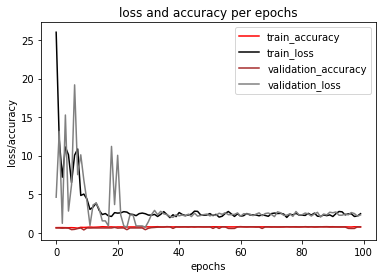

In [15]:
plt.plot(epochs_history.history['accuracy'], c = 'red', label="train_accuracy")
plt.plot(epochs_history.history['loss'], c = 'black', label = 'train_loss')
plt.plot(epochs_history.history['val_accuracy'], c = 'brown', label = 'validation_accuracy')
plt.plot(epochs_history.history['val_loss'], c = 'gray', label = 'validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss/accuracy')
plt.legend(loc="upper right")
plt.title('loss and accuracy per epochs')
plt.show()

In [16]:
_, accuracy = model.evaluate(x_test, y_test)
print('accuracy in test_set: %.2f' %(accuracy*100),'%')

24/24 [==============================] - 2s 93ms/step - loss: 2.3067 - accuracy: 0.7503
accuracy in test_set: 75.03 %


In [17]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis = -1)

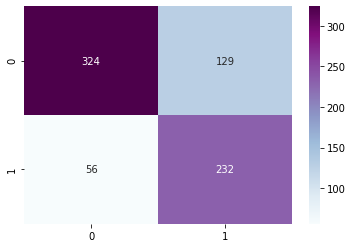

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)
sns.heatmap(cm, annot=True, cmap="BuPu", fmt = 'd')

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
report = classification_report(np.argmax(y_test, axis = 1), y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.72      0.78       453
           1       0.64      0.81      0.71       288

    accuracy                           0.75       741
   macro avg       0.75      0.76      0.75       741
weighted avg       0.77      0.75      0.75       741

